In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from src.utils.seed import set_seed
from src.utils.config import Config
from src.preprocessing import get_data_loaders
from src.models import MLP
from src.uncertainty import MCDropoutEstimator, BayesianRanker

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

c:\Users\surya\anaconda3\envs\tf-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [2]:
config = Config('../configs/config.yaml')
train_loader, val_loader, test_loader, input_dim = get_data_loaders(config)

model = MLP(
    input_dim=input_dim,
    hidden_layers=config.model['mlp']['hidden_layers'],
    dropout=config.model['mlp']['dropout']
).to(device)

model.load_state_dict(torch.load('../reports/results/checkpoints/mlp_best.pth'))
print("✓ Loaded trained MLP model")

✓ Loaded trained MLP model


In [3]:
mc_estimator = MCDropoutEstimator(
    model=model,
    n_samples=config.uncertainty['mc_dropout_samples'],
    device=device
)

print("Running MC Dropout inference...")

X_test_list = []
y_test_list = []

for X, y in test_loader:
    X_test_list.append(X)
    y_test_list.append(y)

X_test = torch.cat(X_test_list)
y_test = torch.cat(y_test_list)

result = mc_estimator.predict(X_test)
mean_preds = result["mean"]
var_preds = result["variance"]

print("✓ Uncertainty estimation complete!")
print(f"Mean predictions shape: {mean_preds.shape}")
print(f"Variance shape: {var_preds.shape}")

Running MC Dropout inference...
✓ Uncertainty estimation complete!
Mean predictions shape: (37376,)
Variance shape: (37376,)


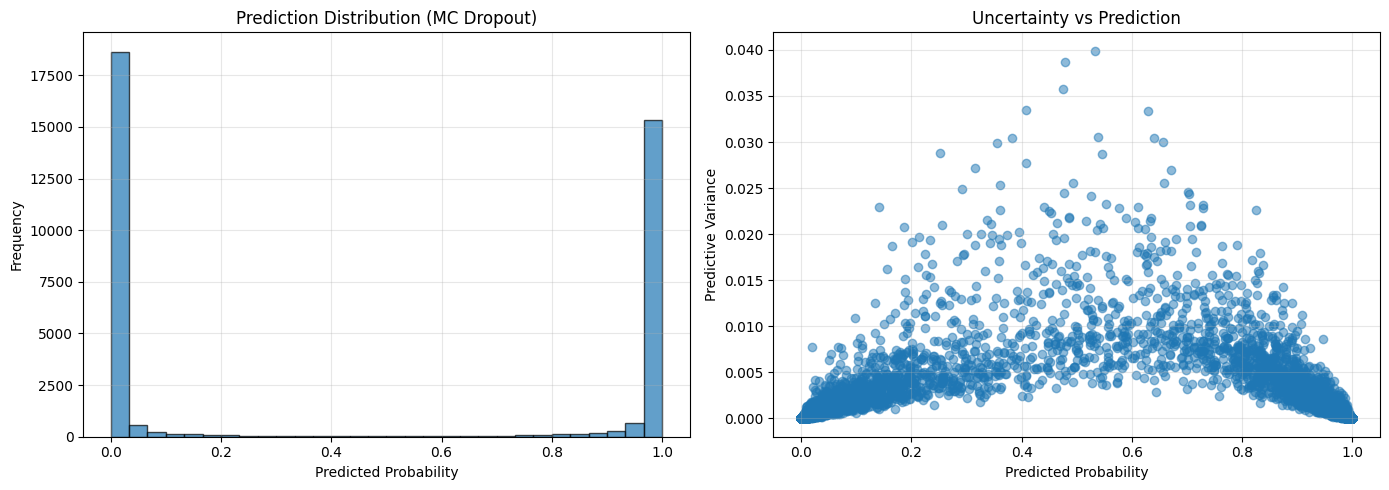

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(mean_preds, bins=30, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Prediction Distribution (MC Dropout)')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(mean_preds, var_preds, alpha=0.5)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Predictive Variance')
axes[1].set_title('Uncertainty vs Prediction')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
ranker = BayesianRanker(confidence_strength=10)

posterior_mean, lower_bound, upper_bound = ranker.compute_posterior(mean_preds, var_preds)
ranked = ranker.rank(mean_preds, var_preds)
ranked_indices = ranked["ranked_indices"]

print("Top 10 ranked variants (with uncertainty):")
for i, idx in enumerate(ranked_indices[:10]):
    print(f"{i+1}. Index {idx}: Mean={posterior_mean[idx]:.4f}, CI=[{lower_bound[idx]:.4f}, {upper_bound[idx]:.4f}]")

Top 10 ranked variants (with uncertainty):
1. Index 0: Mean=1.0000, CI=[1.0000, 1.0000]
2. Index 11945: Mean=1.0000, CI=[1.0000, 1.0000]
3. Index 4712: Mean=1.0000, CI=[1.0000, 1.0000]
4. Index 29144: Mean=1.0000, CI=[1.0000, 1.0000]
5. Index 11940: Mean=1.0000, CI=[1.0000, 1.0000]
6. Index 29137: Mean=1.0000, CI=[1.0000, 1.0000]
7. Index 34107: Mean=1.0000, CI=[1.0000, 1.0000]
8. Index 34108: Mean=1.0000, CI=[1.0000, 1.0000]
9. Index 4710: Mean=1.0000, CI=[1.0000, 1.0000]
10. Index 11956: Mean=1.0000, CI=[1.0000, 1.0000]


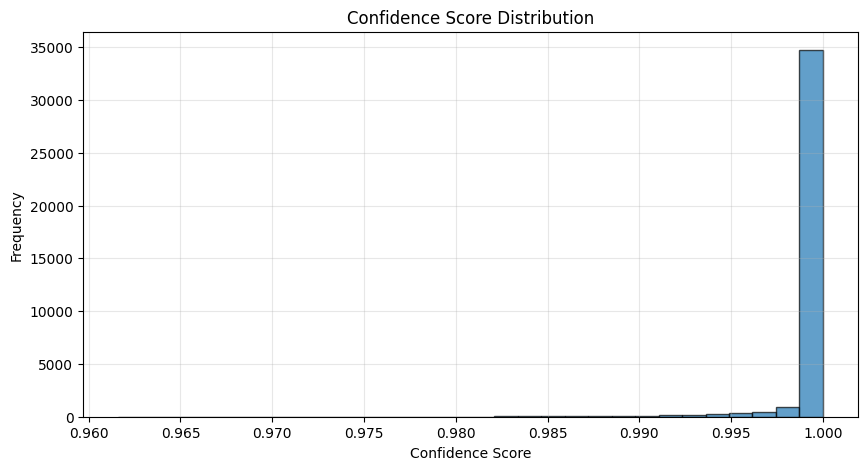

Mean confidence: 0.9996
Std confidence: 0.0019


In [18]:
# Calculate confidence scores based on variance (lower variance = higher confidence)
# We'll use 1/(1 + variance) as a simple confidence metric
confidence_scores = 1 / (1 + var_preds)

plt.figure(figsize=(10, 5))
plt.hist(confidence_scores, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Score Distribution')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean confidence: {confidence_scores.mean():.4f}")
print(f"Std confidence: {confidence_scores.std():.4f}")

In [17]:
print("✓ Uncertainty analysis complete!")

✓ Uncertainty analysis complete!
